# Projet 10 - Moteur de recommandation de contenu

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import os
import glob
import pickle

import datetime

from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
import scipy as sp
import pickle





In [45]:
# verifions quelle category a vu l'utilisateur 59
def usr_pref(user_id) : 
    if user_id not in sorted(clicks['user_id'].unique()) :
        print("user not in database")
    else :
        print(f"User N : {user_id} clicked {clicks[clicks['user_id'] == user_id].shape[0]} times, and view {clicks[clicks['user_id'] == user_id]["category_id"].unique().shape[0]} article's category {clicks[clicks['user_id'] == user_id]["category_id"].unique()}  ")

def reco(user_id, model) :

    idx_user = user_mapping[user_id]
    # recommend items for a user  
    recommendations = model.recommend(idx_user, sparse_matrix[idx_user], N=10)[0].tolist()
    
    articles_recommended = []
    for idx in recommendations :
        for article in article_mapping.items() :
            if article[1] == idx :
                articles_recommended.append(article[0])
                break

    return articles_recommended

def score_reco(l_pred, l_true) :
    score = 0
    for i in l_pred :
        if i in l_true :
            score = 1
    return score

# Exploration des données
Les données sont réparties en trois types de fichier :
 -  articles_metadata.csv : metadonnée sur chaque article
 -  clicks_hour_000.csv : comportement des utilisateurs par session, ID du client et de l'article lu
 -  articles_embeddings.pickle : vecteurs des articles

In [46]:
inputs_path = "/mnt/c/Users/chris/Desktop/formation/10_reco/01_Input/"


# Les lignes commentées sont déjà exécutés pour gagner du temps.

#  articles_metadata = pd.read_csv(inputs_path+'articles_metadata.csv')  
#  # 
#  # # Use glob to list all clicks_hour_001.csv files
#  file_list = glob.glob(inputs_path+"clicks/*clicks_hour*")
#  print(f"Found {len(file_list)} files.")
#  clicks = pd.concat((pd.read_csv(file) for file in file_list), ignore_index=True)
#  print("Files successfully concatenated.") 
#  # 
#  clicks = clicks.sort_values("click_timestamp")
#  clicks = clicks.rename(columns = { "click_article_id" :    "article_id"   })
#  clicks = pd.merge(clicks, articles_metadata, on='article_id', how='left')
#  # 
#  clicks.to_csv(f"{inputs_path}concatenated_clicks_hour.csv", index=False)
#  # # print("Concatenated file saved as 'concatenated_clicks_hour.csv'.")
#  
clicks = pd.read_csv(f"{inputs_path}concatenated_clicks_hour.csv")
clicks["click_timestamp"] = pd.to_datetime(clicks["click_timestamp"], unit='ms')
clicks["created_at_ts"] = pd.to_datetime(clicks["created_at_ts"], unit='ms' )


Vérification des données nulles

In [47]:
clicks.isna().sum()

user_id                0
session_id             0
session_start          0
session_size           0
article_id             0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
category_id            0
created_at_ts          0
publisher_id           0
words_count            0
dtype: int64

In [48]:
clicks.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
0,59,1506826329267796,1506826329000,2,234853,2017-10-01 03:00:00.026,4,3,2,1,21,1,375,2017-09-30 12:18:09,0,140
1,79,1506826486139816,1506826486000,2,159359,2017-10-01 03:00:01.702,4,3,2,1,13,1,281,2017-09-30 07:43:36,0,139
2,154,1506826793323891,1506826793000,2,96663,2017-10-01 03:00:04.207,4,3,2,1,25,7,209,2017-09-30 16:13:45,0,206
3,111,1506826621773848,1506826621000,2,202436,2017-10-01 03:00:14.140,4,3,2,1,9,7,327,2017-09-30 16:15:43,0,333
4,70,1506826416120807,1506826416000,3,119592,2017-10-01 03:00:18.863,4,3,2,1,13,2,247,2017-09-30 15:11:56,0,239


# Nettoyage des données 

Pour simplifier le projet, nous fixons les parametres suivants :

Les articles lus sont des news récentes (créées il y a moins de six mois) et qui ont été vu au moins 10 fois.

In [49]:

clicks = clicks[clicks['created_at_ts'] > pd.to_datetime('2017-04-01')]

article_count = clicks.groupby("article_id").agg(
    count=('article_id', 'size'),
).reset_index()

display(article_count.describe())

list_article = article_count[article_count["count"] > 10]["article_id"].tolist()

clicks_article_filtered = clicks[clicks["article_id"].isin(list_article)]

article_count = clicks_article_filtered.groupby("article_id").agg(
    count=('article_id', 'size'),
).reset_index()

display(article_count.describe())

clicks = clicks_article_filtered.copy()

,article_id,count
count,27228.000000,27228.000000
mean,180995.894300,108.614000
std,103242.717796,815.414537
min,1779.000000,1.000000
25%,89736.250000,1.000000
50%,181952.000000,3.000000
75%,271824.750000,20.000000
max,364046.000000,37213.000000


,article_id,count
count,9179.000000,9179.000000
mean,185934.291862,317.140211
std,103354.139398,1380.886240
min,1843.000000,11.000000
25%,96247.500000,19.000000
50%,190419.000000,39.000000
75%,277090.500000,115.000000
max,363976.000000,37213.000000


# Séparation des jeux de données d'entrainement et de tests

Pour vérifier les prédictions du modèles, il est nécessaire d'avoir une partie du jeu de données pour l'entrainement et une partie de test.  
Les données sont séparées en deux temporellement pour simuler la réalité. Les données d'entrainement sont constitués entre le 01/10/2017 et le 10/10/2017. La prédiction doit trouver les prochaines lectures des utilisateurs entre le 10/10/2017 et le 17/10/2017. 

Pour que l'évaluation puisse avoir lieu nous sélectionnons les users présents avant et après la date ayant lu 10 articles avant et après la date. Les users avec plus de 100 lectures sont considérés comme des outliers.

In [50]:
train_test_date = pd.to_datetime("2017-10-10 00:00:000.000")

clicks_train = clicks[clicks["click_timestamp"] < train_test_date]
clicks_test = clicks[clicks["click_timestamp"] >= train_test_date]

# supression des users avec moins de 10 clicks
user_count = clicks_train.groupby("user_id").agg(
    count=('user_id', 'size'),
).reset_index()
list_user = user_count[(user_count["count"] > 10) & (user_count["count"] < 100)]["user_id"].tolist()
clicks_train = clicks_train[clicks_train["user_id"].isin(list_user)]

user_count = clicks_test.groupby("user_id").agg(
    count=('user_id', 'size'),
).reset_index()
list_user = user_count[(user_count["count"] > 10) & (user_count["count"] < 100)]["user_id"].tolist()
clicks_test = clicks_test[clicks_test["user_id"].isin(list_user)]

# supression des users non présents dans les deux tableaux
clicks_train = clicks_train[clicks_train["user_id"].isin(clicks_test["user_id"].unique().tolist())]
clicks_test = clicks_test[clicks_test["user_id"].isin(clicks_train["user_id"].unique().tolist())]

if sorted(clicks_train['user_id'].unique()) == sorted(clicks_test['user_id'].unique()) :
    print("Les listes users sont identiques dans les deux parties du dataset")

clicks_labels = clicks_test.groupby("user_id").agg(
    labels=("article_id", lambda x: list(x.head(10)))
).reset_index()

Les listes users sont identiques dans les deux parties du dataset


In [51]:
clicks_train

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
0,59,1506826329267796,1506826329000,2,234853,2017-10-01 03:00:00.026,4,3,2,1,21,1,375,2017-09-30 12:18:09,0,140
2,154,1506826793323891,1506826793000,2,96663,2017-10-01 03:00:04.207,4,3,2,1,25,7,209,2017-09-30 16:13:45,0,206
7,59,1506826329267796,1506826329000,2,234995,2017-10-01 03:00:30.026,4,3,2,1,21,1,375,2017-09-30 12:07:16,0,155
8,149,1506826780136886,1506826780000,2,145166,2017-10-01 03:00:31.267,4,3,20,1,26,2,269,2017-09-30 15:27:52,0,180
11,154,1506826793323891,1506826793000,2,108854,2017-10-01 03:00:34.207,4,3,2,1,25,7,230,2017-09-30 21:09:43,0,167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767076,102225,1507592748379656,1507592748000,7,219940,2017-10-09 23:59:55.336,4,1,17,1,2,1,353,2017-10-09 13:54:11,0,48
1767082,17603,1507592995172885,1507592995000,4,271261,2017-10-09 23:59:56.554,4,3,20,1,20,2,399,2017-10-09 18:26:44,0,205
1767086,7532,1507593591166504,1507593591000,4,336223,2017-10-09 23:59:56.937,4,1,17,1,16,2,437,2017-10-09 13:28:20,0,122
1767090,13355,1507592923346817,1507592923000,7,235276,2017-10-09 23:59:57.958,4,3,20,1,21,2,375,2017-10-09 18:46:51,0,203


In [53]:
clicks_labels

,user_id,labels
0,5,"[159190, 282917, 348128, 348091, 348135, 34811..."
1,8,"[119193, 48403, 129165, 336221, 235870, 234698..."
2,10,"[119193, 336223, 141894, 199227, 208500, 33638..."
3,11,"[202330, 208360, 234267, 206735, 202388, 20253..."
4,12,"[235616, 234698, 235854, 337192, 233688, 18317..."
...,...,...
17440,245393,"[277492, 307779, 159938, 284773, 336245, 15927..."
17441,246795,"[313931, 215993, 313920, 314848, 277278, 21599..."
17442,247850,"[289003, 157478, 87215, 234195, 288827, 166380..."
17443,247955,"[214631, 352983, 348130, 352264, 348128, 42226..."


# Modèle 1 Baseline : utilisation des 10 articles les plus populaires

Pour évaluer les modèles nous faisons une comparaison entre les 10 recommandations et les 10 prochaines lectures. Si une des prédictions a été lue alors le modèle marque 1 point. Le score est ensuite établi en faisant le ratio point / individu.

In [54]:
total_score = 0
for user in clicks_labels['user_id'] :
     
    pred_articles = clicks_train['article_id'].value_counts().index[0:10].tolist()
    true_articles = clicks_labels[clicks_labels['user_id'] == user]['labels'].tolist()[0]
    
    
    total_score += score_reco(pred_articles, true_articles)
print(f"\nScore : {round(total_score/clicks_labels.shape[0],5)} ({total_score} / {clicks_labels.shape[0]})")


Score : 0.00138 (24 / 17445)


# Modèle 2 : Collaborative Filtering avec données implicites

Pour ce projet, nous n'avons aucun ranking utilisateur direct. Nous utiliserons donc le nombre de click pour calculer la similarité entre utilisateurs.

Nous utilisons la méthode de factorisation matricielle ALS alternatingleastSquare pour déterminer les meilleures recommandations pour les utilisateurs.

In [72]:
input_matrix = clicks_train.groupby(["user_id", "article_id"]).agg(
    count=('category_id', 'size'),
    category=('category_id', 'first')
).reset_index()

user_mapping = {user_id: idx for idx, user_id in enumerate(input_matrix['user_id'].unique())}
article_mapping = {article_id: idx for idx, article_id in enumerate(input_matrix['article_id'].unique())}

input_matrix['user_idx'] = input_matrix['user_id'].map(user_mapping)
input_matrix['article_idx'] = input_matrix['article_id'].map(article_mapping)

# Create a sparse matrix (rows: users, columns: articles)
sparse_matrix = coo_matrix(
    (input_matrix['count'], (input_matrix['user_idx'], input_matrix['article_idx']))
).tocsr()

results = []
best_param = {}
best_score = 0

for reg in np.logspace(-3, 0, num=4):
    for f in [1, 2, 3, 4, 5, 40] :
        # initialize a model

            
        print(f"Facteur {f} Régularisation {reg}")
        model2 = AlternatingLeastSquares(factors=f, regularization= reg, use_gpu=True)
        
        # train the model on a sparse matrix of user/item/confidence weights
        model2.fit(sparse_matrix)    
        
        
        # Save files
        model2.save("./deploy_local/model_als")
        
        sp.sparse.save_npz("./deploy_local/sparse_matrix", sparse_matrix)
        
        with open("./deploy_local/user_mapping.pkl", "wb") as f:
            pickle.dump(user_mapping, f)
        with open("./deploy_local/article_mapping.pkl", "wb") as g:
            pickle.dump(article_mapping, g)
        
        total_score = 0
        for user in clicks_labels['user_id'] :   
            
            pred_articles = reco(user, model2)
            true_articles = clicks_labels[clicks_labels['user_id'] == user]['labels'].tolist()[0]
            
            
            total_score += score_reco(pred_articles, true_articles)
        print(f"\nScore : {round(total_score/clicks_labels.shape[0],5)} ({total_score} / {clicks_labels.shape[0]})")
        
        if total_score > best_score :
            best_param = {'Regularization': float(reg), 'Factors': int(f), 'Score': round(total_score/clicks_labels.shape[0],5)}
            best_score = total_score 
            
        results.append({'Regularization': float(reg), 'Factors': int(f), 'Score': round(total_score/clicks_labels.shape[0],5)})
        
df_res = pd.DataFrame(results)
df_res.head()

Facteur 1 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 51.82it/s]



Score : 0.07137 (1245 / 17445)
Facteur 2 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.24it/s]



Score : 0.04964 (866 / 17445)
Facteur 3 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.87it/s]



Score : 0.05348 (933 / 17445)
Facteur 4 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 49.73it/s]



Score : 0.04987 (870 / 17445)
Facteur 5 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.68it/s]



Score : 0.04769 (832 / 17445)
Facteur 40 Régularisation 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.02it/s]



Score : 0.02826 (493 / 17445)
Facteur 1 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.34it/s]



Score : 0.07137 (1245 / 17445)
Facteur 2 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.84it/s]



Score : 0.05188 (905 / 17445)
Facteur 3 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.79it/s]



Score : 0.0544 (949 / 17445)
Facteur 4 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.88it/s]



Score : 0.05738 (1001 / 17445)
Facteur 5 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.32it/s]



Score : 0.04712 (822 / 17445)
Facteur 40 Régularisation 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 29.43it/s]



Score : 0.02706 (472 / 17445)
Facteur 1 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.74it/s]



Score : 0.07137 (1245 / 17445)
Facteur 2 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 53.40it/s]



Score : 0.04987 (870 / 17445)
Facteur 3 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.72it/s]



Score : 0.05606 (978 / 17445)
Facteur 4 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.78it/s]



Score : 0.05331 (930 / 17445)
Facteur 5 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.90it/s]



Score : 0.0485 (846 / 17445)
Facteur 40 Régularisation 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.25it/s]



Score : 0.02792 (487 / 17445)
Facteur 1 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.28it/s]



Score : 0.07137 (1245 / 17445)
Facteur 2 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.90it/s]



Score : 0.04345 (758 / 17445)
Facteur 3 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.93it/s]



Score : 0.05308 (926 / 17445)
Facteur 4 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.21it/s]



Score : 0.04821 (841 / 17445)
Facteur 5 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.80it/s]



Score : 0.05079 (886 / 17445)
Facteur 40 Régularisation 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.60it/s]



Score : 0.02935 (512 / 17445)


,Regularization,Factors,Score
0,0.001,1,0.07137
1,0.001,2,0.04964
2,0.001,3,0.05348
3,0.001,4,0.04987
4,0.001,5,0.04769


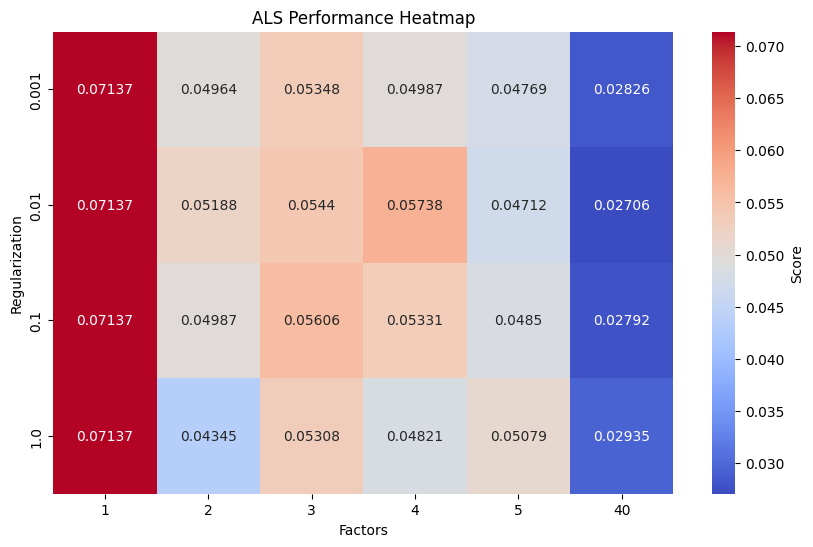

In [73]:

# Pivot the DataFrame for a heatmap-friendly format
heatmap_data = df_res.pivot(index="Regularization", columns="Factors", values="Score")

# Sort axes to ensure correct order
heatmap_data = heatmap_data.sort_index(ascending=True).sort_index(axis=1, ascending=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".5g", cmap="coolwarm", cbar_kws={'label': 'Score'})

plt.title("ALS Performance Heatmap")
plt.xlabel("Factors")
plt.ylabel("Regularization")
plt.show()

In [37]:
# This is a how to for implicit user 1 is similar to 2 so it has been recommended article 2

#   import pandas as pd
#   from scipy.sparse import coo_matrix, csr_matrix
#   from implicit.als import AlternatingLeastSquares
#   
#   # Sample DataFrame
#   data = pd.DataFrame({
#       'user_id': [0,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2,2,2,2],
#       'item_id': [0,0,0,0,1,1,1,1,1, 1,1,1,1,1,1,1,1,1,1, 1,1,1,1,1,2,2,2,2,2,2,2,2],
#       'clicks':  [1,1,1,1,1,10,10,1,1, 1,1,1,1,1,1,1,1,1,1, 1,1,1,1,1,1,1,1,1,1,1,1,1]
#   })
#   
#   # Step 1: Map user_id and item_id to internal indices
#   user_mapping = {user_id: idx for idx, user_id in enumerate(data['user_id'].unique())}
#   item_mapping = {item_id: idx for idx, item_id in enumerate(data['item_id'].unique())}
#   
#   data['user_idx'] = data['user_id'].map(user_mapping)
#   data['item_idx'] = data['item_id'].map(item_mapping)
#   
#   # Step 2: Create a COO sparse matrix
#   interaction_matrix = coo_matrix(
#       (data['clicks'], (data['user_idx'], data['item_idx']))
#   )
#   
#   # Step 3: Convert COO to CSR
#   interaction_matrix_csr = interaction_matrix.tocsr()
#   
#   # Step 4: Initialize and train the ALS model
#   model = AlternatingLeastSquares(factors=50, iterations=20)
#   model.fit(interaction_matrix_csr)
#   
#   # Step 5: Make Recommendations for a User
#   user_id = 1  # External user_id
#   if user_id in user_mapping:
#       user_idx = user_mapping[user_id]  # Map to internal index
#   
#       # Recommend items for the user
#       recommendations = model.recommend(user_idx, interaction_matrix_csr[user_idx])
#   
#   recommendations

# Modèle 3 : Recommandations content based avec cosine similarity

Afin de réaliser les recommandation nous allons devoir vectoriser les lectures déjà réalisées par le client sur la base des fichiers clicks et embeddings.
Le fichier embeddings étant lourd nous réalisons d'abord une PCA en conservant 90% de la variance.


In [74]:
with open(inputs_path+"articles_embeddings.pickle", "rb") as f:
    articles_embeddings = pickle.load(f)
print(f"Number of articles: {len(articles_embeddings)}")

pd.DataFrame(articles_embeddings).describe()

# Step 1: Apply PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance
reduced_embeddings = pca.fit_transform(articles_embeddings)

# Step 2: Print results
print(f"Original dimensions: {articles_embeddings.shape[1]}")
print(f"Reduced dimensions: {reduced_embeddings.shape[1]}")
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2%} of variance retained.")

np.save(inputs_path+"reduced_embeddings.npy", reduced_embeddings)

pd.DataFrame(reduced_embeddings)

Number of articles: 364047
Original dimensions: 250
Reduced dimensions: 40
Explained variance ratio: 90.29% of variance retained.


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-2.176782,1.316913,-1.029049,0.901907,-1.809542,-2.064713,-1.221916,-0.024441,0.927260,-0.669807,...,-0.418769,0.173466,-0.447381,0.603007,0.296159,0.405877,0.658223,-0.234399,-0.031011,0.320311
1,-1.735173,-0.489893,3.268561,0.087855,1.473059,-0.932711,1.841631,-0.881798,-0.207201,0.816808,...,-0.275809,0.161408,-0.148420,-0.172402,0.886631,1.155872,0.247018,-0.092925,-0.765160,-0.427794
2,-0.912688,2.089339,1.865868,-1.202519,2.530601,-0.521970,0.224352,1.479936,-0.191900,1.356801,...,-1.010811,0.643017,0.314196,0.197377,0.407597,0.268160,0.416179,0.251148,0.374923,-0.260145
3,1.096567,-0.212955,4.183517,-0.649575,-0.130867,1.126555,1.063997,-0.662875,0.348143,1.463899,...,-1.356860,0.206190,0.919607,0.612201,1.446416,-0.174685,-0.102416,-0.988858,0.389332,-0.229397
4,0.193785,0.263949,1.896582,-1.834344,1.270378,-1.723296,0.329006,0.283794,-0.659808,1.223740,...,-0.783242,-0.538629,0.278732,0.144277,1.568307,0.958251,0.938803,-0.633343,-0.192695,-0.069261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,1.248788,-5.252167,-0.650815,0.839685,-0.265054,0.623108,0.947454,-0.689414,-0.902330,0.525685,...,-0.601597,0.093079,0.222074,0.238532,0.460731,-0.275959,-0.010327,0.624903,-0.357807,-0.826548
364043,0.575188,-2.392515,-2.702554,5.805813,2.654165,-1.924643,0.672177,-0.958555,-0.938421,0.574798,...,0.577775,-0.133502,-0.018744,-0.213368,0.333173,0.800894,-0.650229,0.382354,0.616968,0.593770
364044,1.564129,-4.053348,2.134535,1.152970,0.980017,0.595264,-0.750342,-1.323827,0.679743,-1.937157,...,0.059228,-0.241593,0.235806,-0.263138,0.264577,-0.641557,-0.373292,-0.014733,0.729262,-1.207712
364045,4.866367,-0.151831,-0.424444,-0.442650,-1.083551,0.659205,-1.366972,-0.764270,-0.182243,0.806381,...,-0.148033,-0.362313,0.225785,-1.015687,0.109959,0.474965,-0.468089,0.147914,0.341197,-0.618116


In [75]:
def compute_embedding(article_ids):
    # Retrieve embeddings for the articles in the list and compute the mean
    embeddings = reduced_embeddings[article_ids]
    return embeddings  # Mean of the embeddings across the articles
last_articles = clicks_train.groupby(["user_id"]).agg(
    article_id=('article_id', 'last'),
).reset_index()

last_articles['article_embedding'] = last_articles['article_id'].apply(compute_embedding)

In [76]:
last_articles

,user_id,article_id,article_embedding
0,5,149622,"[3.8482423, 0.18628252, -1.3767055, 0.43335107..."
1,8,198199,"[-0.55433744, 0.23824883, 0.3070632, -1.780140..."
2,10,68924,"[3.3470538, -0.19886276, -0.6079457, -2.478463..."
3,11,107218,"[4.122364, 0.8592962, -1.4497097, -1.1747298, ..."
4,12,299871,"[-1.5380852, -0.99524426, -1.4189627, -1.66591..."
...,...,...,...
17440,245393,303180,"[-0.7105666, 1.3993336, -0.3135735, 0.4785381,..."
17441,246795,272202,"[-1.3226593, 3.205148, -0.8633651, 1.9453963, ..."
17442,247850,48403,"[-1.3893201, 2.756532, 0.830399, -1.8907623, 2..."
17443,247955,42298,"[0.018116593, -0.09545844, 0.15674931, 0.29103..."


In [78]:
def reco_similarities(embeddings, reduced_embeddings, top_n=10):
    """
    Compute top-N similar articles for a batch of embeddings.
    
    Args:
        embeddings (np.ndarray): 2D array of article embeddings (n_samples x embedding_dim).
        reduce_embeddings (np.ndarray): 2D array of reduced embeddings (n_samples x embedding_dim).
        top_n (int): Number of top similar articles to retrieve.
    
    Returns:
        np.ndarray: 2D array where each row contains indices of top-N similar articles.
    """
    similarities = cosine_similarity(embeddings, reduced_embeddings)
    top_predictions = np.argsort(similarities, axis=1)[:, -top_n:][:, ::-1]
    return top_predictions.tolist()

total_score = 0

for index, row in last_articles.iterrows():
    article_emb = row["article_embedding"].reshape(1, -1)
    user = row["user_id"]
    
    pred_articles = reco_similarities(article_emb,reduced_embeddings)[0]
    true_articles = clicks_labels[clicks_labels['user_id'] == user]['labels'].tolist()[0]
   
    total_score += score_reco(pred_articles, true_articles)
    
print(f"\nScore : {round(total_score/clicks_labels.shape[0],5)} ({total_score} / {clicks_labels.shape[0]})")



Score : 0.01227 (214 / 17445)


Essayons d'améliorer le score en réduisant le fichier embeddings aux seuls articles publiés dans l'année :

In [94]:
df = pd.read_csv(f"{inputs_path}concatenated_clicks_hour.csv")
df["click_timestamp"] = pd.to_datetime(df["click_timestamp"], unit='ms')
df["created_at_ts"] = pd.to_datetime(df["created_at_ts"], unit='ms' )
last_year_article_index = df[df["created_at_ts"] > pd.to_datetime("2017-01-01")]['article_id'].unique()
reduced_embeddings2 = reduced_embeddings[last_year_article_index]

for index, row in last_articles.iterrows():
    article_emb = row["article_embedding"].reshape(1, -1)
    user = row["user_id"]
    
    pred_articles = reco_similarities(article_emb,reduced_embeddings2)[0]
    true_articles = clicks_labels[clicks_labels['user_id'] == user]['labels'].tolist()[0]
   
    total_score += score_reco(pred_articles, true_articles)
    
print(f"\nScore : {round(total_score/clicks_labels.shape[0],5)} ({total_score} / {clicks_labels.shape[0]})")




Score : 0.0 (0 / 17445)


La réduction du nombre d'article ne permet pas d'améliorer le score.

# Conclusion 
-----------

Nous avons testé 3 modèles :  

- Baseline (popularité) : 0.001 

- Modèle context filtering : 0.07

- Modèle content based : 0.01

Le context filtering présente les meilleurs résultats.